# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [194]:
import numpy as np
import pandas as pd
from asl_data import AslDb

asl = AslDb() # initializes the database
#asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

In [195]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [196]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
#asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

##### Try it!

In [197]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x'] 
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-ly  grnd-rx  grnd-lx  
video frame                                      
98    0          113      119        9      -12  
      1          113      119        9      -12  
      2          113      119        9      -12  
      3          113      119        9      -12  
      4          113      119        9      -12

In [198]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [199]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [200]:
training.get_word_Xlengths('CHOCOLATE');

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [201]:
df_means = asl.df.groupby('speaker').mean()
#df_means

To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [202]:
asl.df['left-x-mean'] = asl.df['speaker'].map(df_means['left-x'])
#asl.df.head()

##### Try it!

In [203]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()
#df_std; 

#Now match by speaker
asl.df['left-x-std'] = asl.df['speaker'].map(df_std['left-x'])
#asl.df.head();
# test the code
test_std_tryit(df_std);

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-ly,grnd-rx,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,36.572749,20.269032,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,27.117393,16.764706,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,29.320655,16.191324,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [204]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd
# Get norm-lx as feature

# Left-X
lx_mean = asl.df['speaker'].map(asl.df.groupby('speaker')['left-x'].mean())
lx_std = asl.df['speaker'].map(asl.df.groupby('speaker')['left-x'].std())
asl.df['norm-lx'] = (asl.df['left-x'] - lx_mean)/lx_std
# Left-Y
ly_mean = asl.df['speaker'].map(asl.df.groupby('speaker')['left-y'].mean())
ly_std = asl.df['speaker'].map(asl.df.groupby('speaker')['left-y'].std())
asl.df['norm-ly'] = (asl.df['left-y'] - ly_mean)/ly_std

# Right-X
rx_mean = asl.df['speaker'].map(asl.df.groupby('speaker')['right-x'].mean())
rx_std = asl.df['speaker'].map(asl.df.groupby('speaker')['right-x'].std())
asl.df['norm-rx'] = (asl.df['right-x'] - rx_mean)/rx_std
# Right-Y
ry_mean = asl.df['speaker'].map(asl.df.groupby('speaker')['right-y'].mean())
ry_std = asl.df['speaker'].map(asl.df.groupby('speaker')['right-y'].std())
asl.df['norm-ry'] = (asl.df['right-y'] - ry_mean)/ry_std

#asl.df['norm-lx'] = (asl.df['left-x'] - asl.df['speaker'].map(df_means['left-x']))/asl.df['speaker'].map(df_std['left-x'])
#asl.df['norm-ly'] = (asl.df['left-y'] - asl.df['speaker'].map(df_means['left-y']))/asl.df['speaker'].map(df_std['left-y'])
#asl.df['norm-rx'] = (asl.df['right-x'] - asl.df['speaker'].map(df_means['right-x']) )/asl.df['speaker'].map(df_std['right-x'])
#asl.df['norm-ry'] = (asl.df['right-y'] - asl.df['speaker'].map(df_means['right-y']) )/asl.df['speaker'].map(df_std['right-y'])

# Here is out normalization features list!
features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

In [205]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle   
# Since angle 0 starts from y axis, reverse y and x in np.arctan2(y, x) formular

asl.df['polar-rr']= np.sqrt(np.power(asl.df['grnd-rx'], 2.0) + np.power(asl.df['grnd-ry'], 2.0)) 
asl.df['polar-rtheta'] = np.arctan2(asl.df['grnd-rx'], asl.df['grnd-ry']) 
#asl.df['polar-rtheta'] = np.arcsin(asl.df['grnd-rx']/asl.df['polar-rr'])
#asl.df['polar-rtheta'] = np.arccos(asl.df['grnd-ry']/asl.df['polar-rr'])
asl.df['polar-lr'] = np.sqrt(np.power(asl.df['grnd-lx'], 2.0) + np.power(asl.df['grnd-ly'], 2.0)) 
asl.df['polar-ltheta'] = np.arctan2(asl.df['grnd-lx'], asl.df['grnd-ly']) 
#asl.df['polar-ltheta'] = np.arcsin(asl.df['grnd-lx']/asl.df['polar-lr'])
#asl.df['polar-ltheta'] = np.arccos(asl.df['grnd-ly']/asl.df['polar-lr'])

# Define the polar feature list
features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [206]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'
# calculate difference in columns after 1 period shift  and fill NaN values with 0
asl.df['delta-rx'] = asl.df['right-x'].diff(1).fillna(value=0)
asl.df['delta-ry'] = asl.df['right-y'].diff(1).fillna(value=0)
asl.df['delta-lx'] = asl.df['left-x'].diff(1).fillna(value=0)
asl.df['delta-ly'] = asl.df['left-y'].diff(1).fillna(value=0)

# Define the delta feature list
features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

             best_custom-rx  best_custom-ry  best_custom-lx  best_custom-ly
video frame                                                                
98    0            1.230994        1.557506       -0.808262        0.552186
      1            1.230994        1.557506       -0.808262        0.552186
      2            1.230994        1.557506       -0.808262        0.552186
      3            1.230994        1.557506       -0.808262        0.552186
      4            1.230994        1.557506       -0.808262        0.552186
      5            1.230994        1.557506       -0.808262        0.552186
      6            1.230994        1.557506       -0.808262        0.552186
      7            1.230994        1.557506       -0.808262        0.552186
      8            1.230994        1.557506       -0.808262        0.552186
      9            1.230994        1.557506       -0.808262        0.552186
      10           1.230994        1.557506       -0.808262        0.552186
      11    

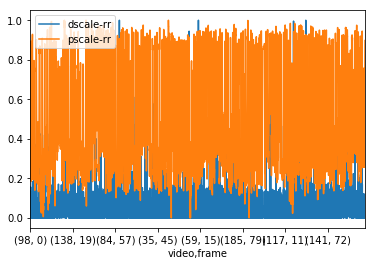

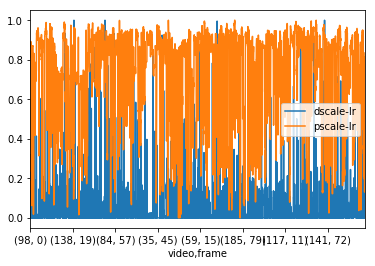

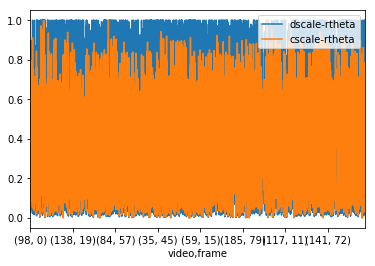

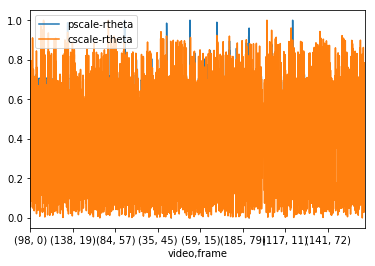

In [208]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like


#Custom Feature 

#Ground Normalization # using Z-score scaling (X-Xmean)/Xstd
#Left-X
glx_mean = asl.df['speaker'].map(asl.df.groupby('speaker')['grnd-lx'].mean())
glx_std = asl.df['speaker'].map(asl.df.groupby('speaker')['grnd-lx'].std())
asl.df['best_custom-lx'] = (asl.df['grnd-lx'] - glx_mean)/glx_std
#Left-Y
gly_mean = asl.df['speaker'].map(asl.df.groupby('speaker')['grnd-ly'].mean())
gly_std = asl.df['speaker'].map(asl.df.groupby('speaker')['grnd-ly'].std())
asl.df['best_custom-ly'] = (asl.df['grnd-ly'] - gly_mean)/gly_std

#Right-X
grx_mean = asl.df['speaker'].map(asl.df.groupby('speaker')['grnd-rx'].mean())
grx_std = asl.df['speaker'].map(asl.df.groupby('speaker')['grnd-rx'].std())
asl.df['best_custom-rx'] = (asl.df['grnd-rx'] - grx_mean)/grx_std

#Right-Y
gry_mean = asl.df['speaker'].map(asl.df.groupby('speaker')['grnd-ry'].mean())
gry_std = asl.df['speaker'].map(asl.df.groupby('speaker')['grnd-ry'].std())
asl.df['best_custom-ry'] = (asl.df['grnd-ry'] - gry_mean)/gry_std

#asl.df['grnd-norm-lx'] = (asl.df['grnd-lx'] - asl.df['speaker'].map(df_means['grnd-lx']))/asl.df['speaker'].map(df_std['grnd-lx']) 
#asl.df['grnd-norm-ly'] = (asl.df['grnd-ly'] - asl.df['speaker'].map(df_means['grnd-ly']))/asl.df['speaker'].map(df_std['grnd-ly']) 
#asl.df['grnd-norm-rx'] = (asl.df['grnd-rx'] - asl.df['speaker'].map(df_means['grnd-rx']) )/asl.df['speaker'].map(df_std['grnd-rx'])
#asl.df['grnd-norm-ry'] = (asl.df['grnd-ry'] - asl.df['speaker'].map(df_means['grnd-ry']) )/asl.df['speaker'].map(df_std['grnd-ry'])

# TODO define a list named 'features_custom' for building the training set
features_custom = ['best_custom-rx', 'best_custom-ry', 'best_custom-lx','best_custom-ly'] 



##################### Important NOTE to GRADER #########################################################
#
# These are some additional custom features which I beleive have some very good performance
# After testing all these features, I have decided to choose as my custom feature(features_custom) 
# as per the requirement, the custom features with the best WER when combined with all 4 models.
# Nevertheless each of these feature list have their individual merits in terms of speed( training time) 
# and accuracy and can each serve as the 'features_custom"
#
########################################################################################################

## Custom Feature list 1
#Custom Feature 1
# Ground Normalization # using Z-score scaling (X-Xmin)/(Xmax - Xmin)
#Left-X
glx_max = asl.df['speaker'].map(asl.df.groupby('speaker')['grnd-lx'].max())
glx_min = asl.df['speaker'].map(asl.df.groupby('speaker')['grnd-lx'].min())
asl.df['gscale-lx'] = (asl.df['grnd-lx'] - glx_min )/(glx_max - glx_min )
#Left-Y
gly_max = asl.df['speaker'].map(asl.df.groupby('speaker')['grnd-ly'].max())
gly_min = asl.df['speaker'].map(asl.df.groupby('speaker')['grnd-ly'].min())
asl.df['gscale-ly'] = (asl.df['grnd-ly'] - gly_min )/(gly_max - gly_min )

#Right-X
grx_max = asl.df['speaker'].map(asl.df.groupby('speaker')['grnd-rx'].max())
grx_min = asl.df['speaker'].map(asl.df.groupby('speaker')['grnd-rx'].min())
asl.df['gscale-rx'] = (asl.df['grnd-rx'] - grx_min )/(grx_max - grx_min )
#Right-Y
gry_max = asl.df['speaker'].map(asl.df.groupby('speaker')['grnd-ry'].max())
gry_min = asl.df['speaker'].map(asl.df.groupby('speaker')['grnd-ry'].min())
asl.df['gscale-ry'] = (asl.df['grnd-ly'] - gry_min )/(gry_max - gry_min )

#df_max = asl.df.groupby('speaker').max()
#df_min = asl.df.groupby('speaker').min()
#asl.df['grnd-scale-lx'] = (asl.df['grnd-lx'] - asl.df['speaker'].map(df_min['grnd-lx']) )/(asl.df['speaker'].map(df_max['grnd-lx']) - asl.df['speaker'].map(df_min['grnd-lx']) )
#asl.df['grnd-scale-ly'] = (asl.df['grnd-ly'] - asl.df['speaker'].map(df_min['grnd-ly']) )/(asl.df['speaker'].map(df_max['grnd-ly']) - asl.df['speaker'].map(df_min['grnd-ly']) ) 
#asl.df['grnd-scale-rx'] = (asl.df['grnd-rx'] - asl.df['speaker'].map(df_min['grnd-rx']) )/(asl.df['speaker'].map(df_max['grnd-rx']) - asl.df['speaker'].map(df_min['grnd-rx']) )
#asl.df['grnd-scale-ry'] = (asl.df['grnd-ry'] - asl.df['speaker'].map(df_min['grnd-ry']) )/(asl.df['speaker'].map(df_max['grnd-ry']) - asl.df['speaker'].map(df_min['grnd-ry']) )

## Custom Feature list 1
features_custom_gscale = ['gscale-rx', 'gscale-ry', 'gscale-lx','gscale-ly'] 



#Custom Feature 2
#Polar Normalization # using Z-score scaling (X-Xmean)/Xstd
#Right-r
prr_mean = asl.df['speaker'].map(asl.df.groupby('speaker')['polar-rr'].mean())
prr_std = asl.df['speaker'].map(asl.df.groupby('speaker')['polar-rr'].std())
asl.df['pnorm-rr'] = (asl.df['polar-rr'] - prr_mean)/prr_std

#Right-Theta
prt_mean = asl.df['speaker'].map(asl.df.groupby('speaker')['polar-rtheta'].mean())
prt_std = asl.df['speaker'].map(asl.df.groupby('speaker')['polar-rtheta'].std())
asl.df['pnorm-rtheta'] = (asl.df['polar-rtheta'] - prt_mean)/prt_std

#Left-r
plr_mean = asl.df['speaker'].map(asl.df.groupby('speaker')['polar-lr'].mean())
plr_std = asl.df['speaker'].map(asl.df.groupby('speaker')['polar-lr'].std())
asl.df['pnorm-lr'] = (asl.df['polar-lr'] - plr_mean)/plr_std

#Left-Theta
plt_mean = asl.df['speaker'].map(asl.df.groupby('speaker')['polar-ltheta'].mean())
plt_std = asl.df['speaker'].map(asl.df.groupby('speaker')['polar-ltheta'].std())
asl.df['pnorm-ltheta'] = (asl.df['polar-ltheta'] - prt_mean)/prt_std

#r_means = asl.df.groupby('speaker').mean()
#r_std = asl.df.groupby('speaker').std()
#asl.df['pnorm-rr'] = (asl.df['polar-rr'] - asl.df['speaker'].map(r_means['polar-rr']) )/asl.df['speaker'].map(r_std['polar-rr'])
#asl.df['pnorm-rtheta'] = (asl.df['polar-rtheta'] - asl.df['speaker'].map(r_means['polar-rtheta']))/asl.df['speaker'].map(r_std['polar-rtheta']) 
#asl.df['pnorm-lr'] = (asl.df['polar-lr'] - asl.df['speaker'].map(r_means['polar-lr']) )/asl.df['speaker'].map(r_std['polar-lr'])
#asl.df['pnorm-ltheta'] = (asl.df['polar-ltheta'] - asl.df['speaker'].map(r_means['polar-ltheta']) )/asl.df['speaker'].map(r_std['polar-ltheta'])

## Custom Feature list 2
features_custom_pnorm = ['pnorm-rr', 'pnorm-rtheta', 'pnorm-lr','pnorm-ltheta'] 


#Custom Feature 3
#Polar Normalization  # using Z-score scaling (X-Xmin)/(Xmax - Xmin)
#Right-r
prr_max = asl.df['speaker'].map(asl.df.groupby('speaker')['polar-rr'].max())
prr_min = asl.df['speaker'].map(asl.df.groupby('speaker')['polar-rr'].min())
asl.df['pscale-rr'] = (asl.df['polar-rr'] - prr_min )/(prr_max - prr_min )
#Right-Theta
prt_max = asl.df['speaker'].map(asl.df.groupby('speaker')['polar-rtheta'].max())
prt_min = asl.df['speaker'].map(asl.df.groupby('speaker')['polar-rtheta'].min())
asl.df['pscale-rtheta'] = (asl.df['polar-rtheta'] - prt_min )/(prt_max - prt_min )

#Left-r
plr_max = asl.df['speaker'].map(asl.df.groupby('speaker')['polar-lr'].max())
plr_min = asl.df['speaker'].map(asl.df.groupby('speaker')['polar-lr'].min())
asl.df['pscale-lr'] = (asl.df['polar-lr'] - plr_min )/(plr_max - plr_min )
#Left-Theta
plt_max = asl.df['speaker'].map(asl.df.groupby('speaker')['polar-ltheta'].max())
plt_min = asl.df['speaker'].map(asl.df.groupby('speaker')['polar-ltheta'].min())
asl.df['pscale-ltheta'] = (asl.df['polar-ltheta'] - plt_min )/(plt_max - plt_min )

# Polar Scaling
#asl.df['pscale-rr'] = (asl.df['polar-rr'] - asl.df['speaker'].map(df_min['polar-rr']) )/(asl.df['speaker'].map(df_max['polar-rr']) - asl.df['speaker'].map(df_min['polar-rr']) )
#asl.df['pscale-rtheta'] = (asl.df['polar-rtheta'] - asl.df['speaker'].map(df_min['polar-rtheta']) )/(asl.df['speaker'].map(df_max['polar-rtheta']) - asl.df['speaker'].map(df_min['polar-rtheta']) )
#asl.df['pscale-lr'] = (asl.df['polar-lr'] - asl.df['speaker'].map(df_min['polar-lr']) )/(asl.df['speaker'].map(df_max['polar-lr']) - asl.df['speaker'].map(df_min['polar-lr']) )
#asl.df['pscale-ltheta'] = (asl.df['polar-ltheta'] - asl.df['speaker'].map(df_min['polar-ltheta']) )/(asl.df['speaker'].map(df_max['polar-ltheta']) - asl.df['speaker'].map(df_min['polar-ltheta']) )

## Custom Feature list 3
features_custom_pscale = ['pscale-rr', 'pscale-rtheta', 'pscale-lr','pscale-ltheta'] 


#Custom Feature 4
#Delta Normalization using Z-score scaling (X-Xmean)/Xstd
#Right-X
drx_mean = asl.df['speaker'].map(asl.df.groupby('speaker')['delta-rx'].mean())
drx_std = asl.df['speaker'].map(asl.df.groupby('speaker')['delta-rx'].std())
asl.df['dnorm-rx'] = (asl.df['delta-rx'] - drx_mean)/drx_std
#Right-Y
dry_mean = asl.df['speaker'].map(asl.df.groupby('speaker')['delta-ry'].mean())
dry_std = asl.df['speaker'].map(asl.df.groupby('speaker')['delta-ry'].std())
asl.df['dnorm-ry'] = (asl.df['delta-ry'] - dry_mean)/dry_std
#Left-X
dlx_mean = asl.df['speaker'].map(asl.df.groupby('speaker')['delta-lx'].mean())
dlx_std = asl.df['speaker'].map(asl.df.groupby('speaker')['delta-lx'].std())
asl.df['dnorm-lx'] = (asl.df['delta-lx'] - dlx_mean)/dlx_std
#Left-Y
dly_mean = asl.df['speaker'].map(asl.df.groupby('speaker')['delta-ly'].mean())
dly_std = asl.df['speaker'].map(asl.df.groupby('speaker')['delta-ly'].std())
asl.df['dnorm-ly'] = (asl.df['delta-ly'] - dly_mean)/dly_std


#asl.df['dnorm-rx'] = (asl.df['delta-rx'] - asl.df['speaker'].map(r_means['delta-rx']) ) / asl.df['speaker'].map(r_std['delta-rx'])
#asl.df['dnorm-ry'] = (asl.df['delta-ry'] - asl.df['speaker'].map(r_means['delta-ry']) ) / asl.df['speaker'].map(r_std['delta-ry'])
#asl.df['dnorm-lx'] = (asl.df['delta-lx'] - asl.df['speaker'].map(r_means['delta-lx']) ) / asl.df['speaker'].map(r_std['delta-lx'])
#asl.df['dnorm-ly'] = (asl.df['delta-ly'] - asl.df['speaker'].map(r_means['delta-ly']) ) / asl.df['speaker'].map(r_std['delta-ly'])

## Custom Feature list 4
features_custom_dnorm = ['dnorm-rx', 'dnorm-ry', 'dnorm-lx','dnorm-ly'] 


#Custom Feature 5
#Delta Normalization using Z-score scaling (X-Xmin)/(Xmax - Xmin)
#Right-X
drx_max = asl.df['speaker'].map(asl.df.groupby('speaker')['delta-rx'].max())
drx_min = asl.df['speaker'].map(asl.df.groupby('speaker')['delta-rx'].min())
asl.df['dscale-rx'] = (asl.df['delta-rx'] - drx_min )/(drx_max - drx_min )
#Right-Y
dry_max = asl.df['speaker'].map(asl.df.groupby('speaker')['delta-ry'].max())
dry_min = asl.df['speaker'].map(asl.df.groupby('speaker')['delta-ry'].min())
asl.df['dscale-ry'] = (asl.df['delta-ry'] - dry_min )/(dry_max - dry_min )

#Left-X
dlx_max = asl.df['speaker'].map(asl.df.groupby('speaker')['delta-lx'].max())
dlx_min = asl.df['speaker'].map(asl.df.groupby('speaker')['delta-lx'].min())
asl.df['dscale-lx'] = (asl.df['delta-lx'] - dlx_min )/(dlx_max - dlx_min )
#Left-Y
dly_max = asl.df['speaker'].map(asl.df.groupby('speaker')['delta-ly'].max())
dly_min = asl.df['speaker'].map(asl.df.groupby('speaker')['delta-ly'].min())
asl.df['dscale-ly'] = (asl.df['delta-ly'] - dly_min )/(dly_max - dly_min )

#asl.df['dscale-rx'] = (asl.df['delta-rx'] - asl.df['speaker'].map(df_min['delta-rx']) )/(asl.df['speaker'].map(df_max['delta-rx']) - asl.df['speaker'].map(df_min['delta-rx']) )
#asl.df['dscale-ry'] = (asl.df['delta-ry'] - asl.df['speaker'].map(df_min['delta-ry']) )/(asl.df['speaker'].map(df_max['delta-ry']) - asl.df['speaker'].map(df_min['delta-ry']) )
#asl.df['dscale-lx'] = (asl.df['delta-lx'] - asl.df['speaker'].map(df_min['delta-lx']) )/(asl.df['speaker'].map(df_max['delta-lx']) - asl.df['speaker'].map(df_min['delta-lx']) )
#asl.df['dscale-ly'] = (asl.df['delta-ly'] - asl.df['speaker'].map(df_min['delta-ly']) )/(asl.df['speaker'].map(df_max['delta-ly']) - asl.df['speaker'].map(df_min['delta-ly']) )

## Custom Feature list 5
features_custom_dscale = ['dscale-rx', 'dscale-ry', 'dscale-lx','dscale-ly'] 


## Custom Feature 6
# How to combine al these to a specific robust feature?
# Make them unitless and add them?
# first normalise all the features to a common range using feature scaling
# we define custom-X = Ground-X*Delta-X/(Ground-X + Delta-X) in (x-y) cordinates
# and then scale it so numbers are within [0, 1] as above scales

# A similar definition using Polar cordinates(r,theta) would require
# that we first transform Delta-X to Polar form as done above before combining it with
# the Polar-r. This is similar to the complex transformation Z = Zo + A*exp(i*theta)

# custume Feature( fuction of ground and Delta): Scaling is sort of weighted contribution!
asl.df['custom-lx'] = asl.df['gscale-lx'] * asl.df['dscale-lx'] /(asl.df['gscale-lx'] + asl.df['dscale-lx'])
asl.df['custom-ly'] = asl.df['gscale-ly'] * asl.df['dscale-ly'] /(asl.df['gscale-ly'] + asl.df['dscale-ly'])
asl.df['custom-rx'] = asl.df['gscale-rx'] * asl.df['dscale-rx'] /(asl.df['gscale-rx'] + asl.df['dscale-rx'])
asl.df['custom-ry'] = asl.df['gscale-ry'] * asl.df['dscale-ry'] /(asl.df['gscale-ry'] + asl.df['dscale-ry'])



## Now lets scale the features with X' = (X - min(X))/max(X) - min(X)
## Custom (Normaliation)Scaled Feature
#Right-X
crx_max = asl.df['speaker'].map(asl.df.groupby('speaker')['custom-rx'].max())
crx_min = asl.df['speaker'].map(asl.df.groupby('speaker')['custom-rx'].min())
asl.df['cscale-rx'] = (asl.df['custom-rx'] - crx_min )/(crx_max - crx_min )
#Right-Y
cry_max = asl.df['speaker'].map(asl.df.groupby('speaker')['custom-ry'].max())
cry_min = asl.df['speaker'].map(asl.df.groupby('speaker')['custom-ry'].min())
asl.df['cscale-ry'] = (asl.df['custom-ry'] - cry_min )/(cry_max - cry_min )

#Left-X
clx_max = asl.df['speaker'].map(asl.df.groupby('speaker')['custom-lx'].max())
clx_min = asl.df['speaker'].map(asl.df.groupby('speaker')['custom-lx'].min())
asl.df['cscale-lx'] = (asl.df['custom-lx'] - clx_min )/(clx_max - clx_min )
#Left-Y
cly_max = asl.df['speaker'].map(asl.df.groupby('speaker')['custom-ly'].max())
cly_min = asl.df['speaker'].map(asl.df.groupby('speaker')['custom-ly'].min())
asl.df['cscale-ly'] = (asl.df['custom-ly'] - cly_min )/(cly_max - cly_min )



## redefining max and min for prevent errors popping up!
#cf_max = asl.df.groupby('speaker').max()
#cf_min = asl.df.groupby('speaker').min()
#asl.df['cscale-rx'] = (asl.df['custom-lx'] - asl.df['speaker'].map(cf_min['custom-lx']) )/(asl.df['speaker'].map(cf_max['custom-lx']) - asl.df['speaker'].map(cf_min['custom-lx']) )
#asl.df['cscale-ry'] = (asl.df['custom-ly'] - asl.df['speaker'].map(cf_min['custom-ly']) )/(asl.df['speaker'].map(cf_max['custom-ly']) - asl.df['speaker'].map(cf_min['custom-ly']) )
#asl.df['cscale-lx'] = (asl.df['custom-rx'] - asl.df['speaker'].map(cf_min['custom-rx']) )/(asl.df['speaker'].map(cf_max['custom-rx']) - asl.df['speaker'].map(cf_min['custom-rx']) )
#asl.df['cscale-ly'] = (asl.df['custom-ry'] - asl.df['speaker'].map(cf_min['custom-ry']) )/(asl.df['speaker'].map(cf_max['custom-ry']) - asl.df['speaker'].map(cf_min['custom-ry']) )

# Custom Features 6 list!
features_custom_scale = ['cscale-rx', 'cscale-ry', 'cscale-lx','cscale-ly']


## Custom Feature 6
# How to combine al these to a specific robust feature?
# Make them unitless and add them?
# first normalise all the features to a common range using feature scaling
# we define custom-r = Polar-r*Delta-r/(Polar-r + Delta-r) in (r-theta) cordinates
# and then scale it so numbers are within [0, 1] as above scales
# This is similar to the complex transformation Z = Zo + A*exp(i*theta)
asl.df['delta-rr']= np.sqrt(np.power(asl.df['delta-rx'], 2.0) + np.power(asl.df['delta-ry'], 2.0)) 
asl.df['delta-rtheta'] = np.arctan2(asl.df['delta-rx'], asl.df['delta-ry']) 
asl.df['delta-lr'] = np.sqrt(np.power(asl.df['delta-lx'], 2.0) + np.power(asl.df['delta-ly'], 2.0)) 
asl.df['delta-ltheta'] = np.arctan2(asl.df['delta-lx'], asl.df['delta-ly']) 

## Now scale the Polar of the delta to X' = (X - min(X))/max(X) - min(X)
#Right-r
drr_max = asl.df['speaker'].map(asl.df.groupby('speaker')['delta-rr'].max())
drr_min = asl.df['speaker'].map(asl.df.groupby('speaker')['delta-rr'].min())
asl.df['dscale-rr'] = (asl.df['delta-rr'] - drr_min )/(drr_max - drr_min )
#Right-Theta
drt_max = asl.df['speaker'].map(asl.df.groupby('speaker')['delta-rtheta'].max())
drt_min = asl.df['speaker'].map(asl.df.groupby('speaker')['delta-rtheta'].min())
asl.df['dscale-rtheta'] = (asl.df['delta-rtheta'] - drt_min )/(drt_max - drt_min )

#Left-r
dlr_max = asl.df['speaker'].map(asl.df.groupby('speaker')['delta-lr'].max())
dlr_min = asl.df['speaker'].map(asl.df.groupby('speaker')['delta-lr'].min())
asl.df['dscale-lr'] = (asl.df['delta-lr'] - dlr_min )/(dlr_max - dlr_min )
#Left-Theta
dlt_max = asl.df['speaker'].map(asl.df.groupby('speaker')['delta-ltheta'].max())
dlt_min = asl.df['speaker'].map(asl.df.groupby('speaker')['delta-ltheta'].min())
asl.df['dscale-ltheta'] = (asl.df['delta-ltheta'] - dlt_min )/(dlt_max - dlt_min )


## Now lets Weight each Contribution(Scaled Ground and Delta in Polar Cordinates)
# custume Feature( fuction of Scaled ground and Delta): Scaling is sort of weighted contribution!
asl.df['custom-rr'] = asl.df['pscale-rr'] * asl.df['dscale-rr'] /(asl.df['pscale-rr'] + asl.df['dscale-rr'])
asl.df['custom-rtheta'] = asl.df['pscale-rtheta'] * asl.df['dscale-rtheta'] /(asl.df['pscale-rtheta'] + asl.df['dscale-rtheta'])
asl.df['custom-lr'] = asl.df['pscale-lr'] * asl.df['dscale-lr'] /(asl.df['pscale-lr'] + asl.df['dscale-lr'])
asl.df['custom-ltheta'] = asl.df['pscale-ltheta'] * asl.df['dscale-ltheta'] /(asl.df['pscale-ltheta'] + asl.df['dscale-ltheta'])


## Now we scale the custom polar cordinates generated from the weighted scaled Ground and Delta Polar cordinates
# We are scaling the custom polar features with X' = (X - min(X))/max(X) - min(X)
#Right-r
crr_max = asl.df['speaker'].map(asl.df.groupby('speaker')['custom-rr'].max())
crr_min = asl.df['speaker'].map(asl.df.groupby('speaker')['custom-rr'].min())
asl.df['cscale-rr'] = (asl.df['custom-rr'] - crr_min )/(crr_max - crr_min )
#Right-theta
crt_max = asl.df['speaker'].map(asl.df.groupby('speaker')['custom-rtheta'].max())
crt_min = asl.df['speaker'].map(asl.df.groupby('speaker')['custom-rtheta'].min())
asl.df['cscale-rtheta'] = (asl.df['custom-rtheta'] - crt_min )/(crt_max - crt_min )

#Left-r
clr_max = asl.df['speaker'].map(asl.df.groupby('speaker')['custom-lr'].max())
clr_min = asl.df['speaker'].map(asl.df.groupby('speaker')['custom-lr'].min())
asl.df['cscale-lr'] = (asl.df['custom-lr'] - clr_min )/(clr_max - clr_min )
#Left-theta
clt_max = asl.df['speaker'].map(asl.df.groupby('speaker')['custom-ltheta'].max())
clt_min = asl.df['speaker'].map(asl.df.groupby('speaker')['custom-ltheta'].min())
asl.df['cscale-ltheta'] = (asl.df['custom-ltheta'] - clt_min )/(clt_max - clt_min )

# Custom Features 6 list!
features_custom_gnorm = ['cscale-rr', 'cscale-rtheta', 'cscale-lr','cscale-ltheta']

#asl.df
#asl.df.drop(['best_custom-lx','best_custom-ly','best_custom-rx','best_custom-ry'],axis=1,inplace=True)                                                                                             
#asl.df.drop(['pnorm-rr', 'pnorm-rtheta', 'pnorm-lr','pnorm-ltheta'],axis=1,inplace=True)
#asl.df.drop(['delta-rx-norm','delta-ry-norm','delta-lx-norm','delta-ly-norm'],axis=1,inplace=True)


#Debugging  
#print(asl.df.head());
#asl.df.index
#asl.df.describe()
#print(asl.df.columns)
#asl.df.info();
#print(asl.df.head());
##prr = asl.df['polar-rr']
##prrmean = asl.df['speaker'].map(df_means['polar-rr']) 
##prrstd = asl.df['speaker'].map(df_std['polar-rr']) 
##prrnorm = [(r-m)/d for r in prr for m in prrmean for d in prrstd ] 
%matplotlib inline
import matplotlib.pyplot as plt

"""
# Using Normal Distribution Normalisation
plt.figure(figsize = (20.0,15.0))
plt.subplot(1,4,1)
asl.df['grnd-norm-lx'].plot()
plt.title('Ground Norm')
plt.subplot(1,4,2)
asl.df['polar-lr-norm'].plot()
plt.title('Polar Norm')
plt.subplot(1,4,3)
asl.df['delta-lx-norm'].plot()
plt.title('Delta Norm')

"""

"""
## Using Scaling
plt.figure(figsize = (20.0,15.0))
plt.subplot(1,4,1)
asl.df['grnd-scale-lx'].plot()
plt.title('Ground Scale')
plt.subplot(1,4,2)
asl.df['polar-lr-scale'].plot()
plt.title('Polar Scale')
plt.subplot(1,4,3)
asl.df['delta-lx-scale'].plot()
plt.title('Delta Scale')
"""

"""
#plt.figure(figsize = (20.0,15.0))
asl.df[['grnd-norm-lx', 'pnorm-lr']].plot()
asl.df[['grnd-scale-lx', 'pscale-lr']].plot()
asl.df[['grnd-norm-lx', 'dnorm-lx']].plot()
asl.df[['pnorm-lr', 'dnorm-lx']].plot()
asl.df[['best_custom-lx', 'pnorm-lr','dnorm-lx']].plot()
asl.df[['gscale-lx', 'pscale-lr','dscale-lx']].plot()
"""

plt.figure(figsize = (20.0,15.0))
asl.df[['dscale-rr', 'pscale-rr']].plot()
asl.df[['dscale-lr', 'pscale-lr']].plot()
asl.df[['dscale-rtheta', 'cscale-rtheta']].plot()
asl.df[['pscale-rtheta', 'cscale-rtheta']].plot()

#plt.show()
print(asl.df[['best_custom-rx','best_custom-ry','best_custom-lx','best_custom-ly']])

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**
We defined many custom features which we think have excellent performance in terms of speed( training time) and accuracy. Amongst these custom features(features_custom_pscale, features_custom_pnorm, features_custom_gnorm,
features_custom_gscale, features_custom_dnorm, features_custom_dscale and features_custom_scale)
we have decided to choose as our "features_custom" the custom features with the best overall performance
in speed and accuracy when combined with the selection models. This selected feature custom is simply the 
normalization of the ground using the Z-score scaling (X-Xmean)/Xstd resulting to a Gaussian distribution with 
 mean = 0 and std = 1. This selected features_custom had the best WER ratio compared to other custom features
 however, some custom features like (features_custom_pscale,features_custom_gscale, features_custom_dscale, features_custom_scale which were normalized using x_new = x_old - min(x_old)/max(x_old) ) had the best speed or training time.

Custom features from a combination the scaled ground (x-y) and (r-theta) cordinates with the scaled (x-y) and (r-theta) delta cordinates to produced our custom scaled (x-y) and (r-theta) cordinated which is itself scaled equally produce excellent results(WER). The normalization of these uses the geneal form x_new = x_old - min(x_old)/max(x_old) - min(x_old) where x_new is our new normalized cordinate. The resulting custom feature combines the new cordinates of ground and delta in a way that allows for a weighted contribution for each cordinate since we believe both features can be complimentary to each other as shown on the resulting plots comparing the distribution of these features. Thus using both features can be powerful . The motivation is
to defined a features that is very dynamic to model selection choice.
by allowing both the ground and delta contributions accordingly to the custom features. Its a shame that the WER for these( which have the fastest training time) is a bit high(0.70).


<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [209]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3) 

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.016s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [274]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.113812743321


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [275]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]

hidden state #1
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #2
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [276]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ -9.30211403  55.32333876   6.92259936  71.24057775]
variance =  [ 16.16920957  46.50917372   3.81388185  15.79446427]

hidden state #1
mean =  [   0.58333333   87.91666667   12.75        108.5       ]
variance =  [  39.41055556   18.74388889    9.855       144.4175    ]

hidden state #2
mean =  [ -5.40587658  60.1652424    2.32479599  91.3095432 ]
variance =  [   7.95073876   64.13103127   13.68077479  129.5912395 ]

logL = -601.3291470028641


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

**Answer**

Models with narrower Gaussian(of mean and variance) distribution in a HMM state  are better models.


In [277]:
%matplotlib inline

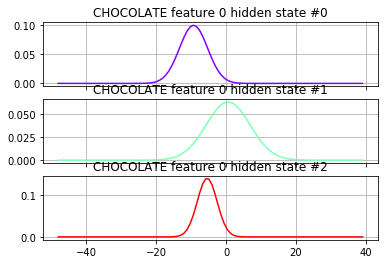

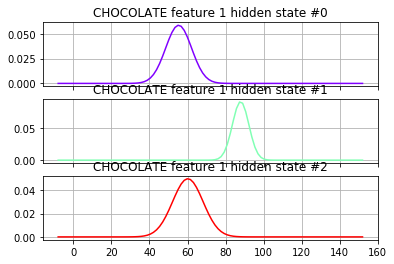

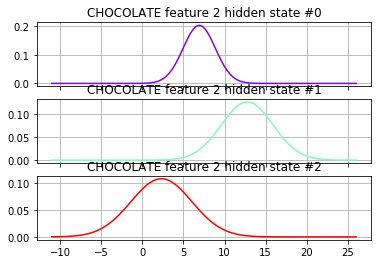

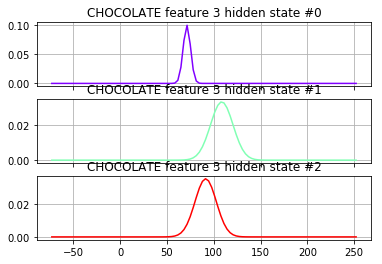

In [278]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [279]:
from my_model_selectors import SelectorConstant

#training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
training = asl.build_training(features_custom)
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [280]:
from sklearn.model_selection import KFold

training = asl.build_training(features_custom) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [281]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [293]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV
#features_custom_gscale for JOHN = 28.239 sec
#features_custom_dscale for JOHN = 26.934 sec
#features_custom_pscale for JOHN = 26.718 sec
#features_custom_scale for JOHN = 23.932 sec  ## Best speed performance?
#features_custom_gnorm for JOHN = 46.781 sec

#features_custom for JOHN = 30.433 sec
#features_custom_pnorm for JOHN = 35.020 sec

#features_ground for JOHN = 29.824 sec
#features_polar for JOHN = 38.818 sec
#features_delta for JOHN = 341.057 sec

training = asl.build_training(features_custom_scale)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model =  SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.3762078119907528 seconds
Training complete for BOOK with 3 states with time 3.122298879083246 seconds
Training complete for VEGETABLE with 3 states with time 0.9626189949922264 seconds
Training complete for FUTURE with 3 states with time 3.326001255074516 seconds
Training complete for JOHN with 3 states with time 24.49839735205751 seconds


In [294]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC
#features_custom_gscale for JOHN = 24.4777 sec
#features_custom_dscale for JOHN = 27.647 sec
#features_custom_pscale for JOHN = 26.197 sec
#features_custom_scale for JOHN = 24.567 sec  # Best speed performance?
#features_custom_gnorm for JOHN = 47.711 sec

#features_custom for JOHN = 30.746 sec
#features_custom_pnorm for JOHN = 35.607 sec

#features_ground for JOHN = 29.657 sec
#features_polar for JOHN = 40.661 sec
#features_delta for JOHN = 39.291 sec

training = asl.build_training(features_custom_scale)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 0.37409071205183864 seconds
Training complete for BOOK with 2 states with time 2.991846570977941 seconds
Training complete for VEGETABLE with 2 states with time 1.0021836549276486 seconds
Training complete for FUTURE with 2 states with time 2.941439884947613 seconds
Training complete for JOHN with 2 states with time 24.207925659022294 seconds


In [296]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC
#features_custom_gscale for JOHN = 29.091 sec
#features_custom_dscale for JOHN = 33.761 sec
#features_custom_pscale for JOHN = 32.563 sec
#features_custom_scale for JOHN = 28.823 sec  ## Best speed performance?
#features_custom_gnorm for JOHN = 51.244 sec

#features_custom for JOHN = 36.617 sec
#features_custom_pnorm for JOHN = 39.393 sec


#features_ground for JOHN = 38.164 sec
#features_polar for JOHN = 45.040 sec
#features_delta for JOHN = 49.635 sec

training = asl.build_training(features_custom_scale)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 3.2131812549196184 seconds
Training complete for BOOK with 4 states with time 5.963117046980187 seconds
Training complete for VEGETABLE with 2 states with time 3.842595533002168 seconds
Training complete for FUTURE with 7 states with time 5.825170807074755 seconds
Training complete for JOHN with 15 states with time 28.353748823981732 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

** SelectorCV: Log likelihood with CV**

The CV or Cross Validation method is a model selection technique which allows you to split a given data set(training set) into folds(seperate parts) and use one fold of the many folds for validation of a model while the rest of the folds are used for training. The next time a training is performed a fold completely different from the previously selected fold used for validation is now used for validation or testing of our model while the rest is again used for training. By repeated spliting your data sets into training and testing(validation) and the reassigning your validation set or fold and another fold used for tetsing during the entire training  process, we can reliably know the effectiveness of our model performance.

The best model to be selected is the model which has the best average score on the test sets. This entire procedure prevents overfitting.
The major disavantage of the CV approach is that we are training and testing our model on a "similar" data set which can result to higher bias especially if the size of the folds are small.

** SelectorBIC: Bayesian Information Criterion **

The BIC is a model selection tool which allows the selection of a given model based scores computed on a training data. The scores give an estimate of the model performance on a new fresh data set(test set). The BIC score is given by

BIC = -2*logL - p*logN

where logL is the loglikelihood, N is the sample size of the training set and p is the total number of parameters( for the case of HMM, p = Initial State Occupation Probabilities + Transition probabilities + Emission Probabilities or p = NumberOfStates * NumberofStates + Number of Means of model + Number of covariances of model).

The model with the smallest BIC value over the wholse set of candidates is selected as the best model.

BIC attempts to mitigate the risk of over-fitting by introducing a penalty term (p * logN). This pernalty term grows as the number of parameters of the model grows. Thus we can use the BIC to filter out unnecessarily complicated models which always have too many parameters to be estimated accurately on a given data set of size N.Thus the BIC model is inherently biased in favor of less complicated or simpler models.

** SelectorDIC: Discriminative Information Criterion **

The DIC is equally a model selection tool with a score, DIC, which when estimated on a training set the DIC score gives an estimate of the model performance on a fresh data(test set). The DIC is computed on a training set for a given value (e.g given word in speech recognision models) by subtracting the loglikelihood(probability) of the given value (word) from an average loglikelihood of all the other possibles values(or words) except the given value(word). DIC is computed using the formula:

DIC = log(P(x = given word)  - 1/(M-1)Sum(log(P(all words except x = given word))

M is the count of times and log(P) is the loglikelihood. From the equation in order to get the average probability we have to compute the model score for M-1 data samples and this is time consuming. Because of this, the DIC approach is very slow( time consuming). However it is very accurate and is not biased towards any kind of models( complex of simple models).

** Comparing these Techniques **

As seen from our previous training example, the SelectorCV is fast for computing, however, if we have to many folds or split our data too much we risk introducing a higher bias( bias towards the given training set) and hence the model fails to generalised on a fresh or new data.

The SelectorBIC is also fast for compute however the BIC technique is very biased towards simple models and does not perform quite well for complicated models or models with many parameters especially in HMM models with higher number of states.

The SelectorDIC model is unbiased towards any kind of models, but if we have a large sample size, it will take a lot of time( as can be seen in the time used to train the word JOHN shown in the commented section of the code in the different techiniques) as this time is consumed by computing the average probability or loglikelihood.



<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [298]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

...

DIC SumLogP not computed for word = JOHN
DIC SumLogP not computed for word = WRITE
DIC SumLogP not computed for word = HOMEWORK
DIC SumLogP not computed for word = IX-1P
DIC SumLogP not computed for word = SEE
DIC SumLogP not computed for word = YESTERDAY
DIC SumLogP not computed for word = IX
DIC SumLogP not computed for word = LOVE
DIC SumLogP not computed for word = MARY
DIC SumLogP not computed for word = CAN
DIC SumLogP not computed for word = GO
DIC SumLogP not computed for word = GO1
DIC SumLogP not computed for word = FUTURE
DIC SumLogP not computed for word = GO2
DIC SumLogP not computed for word = PARTY
DIC SumLogP not computed for word = FUTURE1
DIC SumLogP not computed for word = HIT
DIC SumLogP not computed for word = BLAME
DIC SumLogP not computed for word = FRED
DIC SumLogP not computed for word = FISH
DIC SumLogP not computed for word = WONT
DIC SumLogP not computed for word = EAT
DIC SumLogP not computed for word = BUT
DIC SumLogP not computed for word = CHICKEN
DIC Su

.

DIC SumLogP not computed for word = APPLE
DIC SumLogP not computed for word = NAME
DIC SumLogP not computed for word = SHOOT
DIC SumLogP not computed for word = SAY-1P
DIC SumLogP not computed for word = SELF
DIC SumLogP not computed for word = GROUP
DIC SumLogP not computed for word = JANA
DIC SumLogP not computed for word = TOY1
DIC SumLogP not computed for word = MANY
DIC SumLogP not computed for word = ALL
DIC SumLogP not computed for word = BOY
DIC SumLogP not computed for word = TEACHER
DIC SumLogP not computed for word = GIRL
DIC SumLogP not computed for word = BOX
DIC SumLogP not computed for word = GIVE2
DIC SumLogP not computed for word = GIVE3
DIC SumLogP not computed for word = GET
DIC SumLogP not computed for word = PUTASIDE
 Unable to Compute DIC LogL



----------------------------------------------------------------------
Ran 4 tests in 52.829s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [302]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_custom, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [303]:
test_set = asl.build_test(features_custom)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [304]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [317]:
# Testing feature sets and model selectors
# change as needed
#features = features_custom_scale
#features = features_custom_gscale 
#features = features_custom_pscale
#features = features_custom_dscale
#features = features_custom_pnorm
#features = features_custom_gnorm
#features = features_custom_dnorm
#features = features_ground 
#features = features_polar 
#features = features_delta 
#features = features_custom 
#features = features_norm

##**** WER = 0.5561797752808989 Total correct: 79 out of 178
features = features_custom_scale + features_custom_gscale + features_custom_pscale + features_custom_pnorm \
           + features_custom_dscale + features_custom_dnorm
           

# change as needed
#model_selector = SelectorConstant 
model_selector = SelectorCV
#model_selector = SelectorBIC
#model_selector = SelectorDIC

# Display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5561797752808989
Total correct: 79 out of 178
Video  Recognized                                                    Correct
    2: *POSS WRITE HOMEWORK                                          JOHN WRITE HOMEWORK
    7: JOHN *DECIDE *VISIT *CAR                                      JOHN CAN GO CAN
   12: *IX CAN *GO1 CAN                                              JOHN CAN GO CAN
   21: *IX *NEW WONT *MARY BUT *GO EAT CHICKEN                       JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *ANN LIKE IX *LIKE IX                                         JOHN LIKE IX IX IX
   28: *IX LIKE *LIKE *LIKE *LIKE                                    JOHN LIKE IX IX IX
   30: JOHN *MARY *MARY *MARY *GIVE                                  JOHN LIKE IX IX IX
   36: MARY *PREFER *GIRL *GIVE *GO *MARY                            MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *BILL *CORN MARY *MARY                                  JOHN IX THINK MARY LOVE
   43: *FRANK *POSS BUY HOUSE       

In [315]:
# **** WER = 0.5786516853932584
#  Total correct: 75 out of 178
#
features = features_ground + features_norm + features_polar + features_delta + features_custom 


#Model Selected
model_selector = SelectorCV 


models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5786516853932584
Total correct: 75 out of 178
Video  Recognized                                                    Correct
    2: *POSS WRITE HOMEWORK                                          JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE *VISIT *ARRIVE                                   JOHN CAN GO CAN
   12: JOHN *HAVE *WHAT CAN                                          JOHN CAN GO CAN
   21: JOHN *NEW *JOHN *MARY *CAR *CAR *VISIT *WHO                   JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *IX LIKE IX *LIKE IX                                          JOHN LIKE IX IX IX
   28: *MARY *MARY IX *LIKE IX                                       JOHN LIKE IX IX IX
   30: *MARY LIKE *MARY *MARY *MARY                                  JOHN LIKE IX IX IX
   36: MARY *JOHN *IX *GIVE *IX *MARY                                MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *MARY *CORN MARY *MARY                                   JOHN IX THINK MARY LOVE
   43: *FRANK *POSS BUY HOUSE       

In [318]:

#
# **** WER = 0.5786516853932584
#  Total correct: 75 out of 178
#
features = features_ground + features_norm + features_polar + features_delta  
#Model Selected
model_selector = SelectorBIC 


models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5337078651685393
Total correct: 83 out of 178
Video  Recognized                                                    Correct
    2: *POSS WRITE *ARRIVE                                           JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE *VISIT *CAR                                      JOHN CAN GO CAN
   12: JOHN CAN *GO1 CAN                                             JOHN CAN GO CAN
   21: JOHN *VIDEOTAPE *SOMETHING-ONE *SEE *CAR *CAR *VISIT *MARY    JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE *MARY *WHO *LOVE                                    JOHN LIKE IX IX IX
   28: JOHN *WHO *MARY *LIKE *LOVE                                   JOHN LIKE IX IX IX
   30: *LIKE LIKE *MARY *MARY IX                                     JOHN LIKE IX IX IX
   36: MARY *MARY *IX *GIVE *MARY *MARY                              MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *MARY *CORN MARY *MARY                                   JOHN IX THINK MARY LOVE
   43: JOHN *POSS BUY HOUSE         

In [ ]:
#TODO Choose a feature set and model selector
#########################################################################################
#                    3rd Best Single feature + Model Combination with WER = 0.6123
#########################################################################################
features = features_delta
#Model Selected
model_selector = SelectorBIC 
#TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

In [ ]:
#TODO Choose a feature set and model selector
#
#########################################################################################
#                   2nd Best Single feature + Model Combination with WER = 0.6011
#########################################################################################
features = features_custom
#Model Selected
model_selector = SelectorCV 
#TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

In [ ]:
#TODO Choose a feature set and model selector

#########################################################################################
#                   Best Single feature + Model Combination with WER = 0.5112
#########################################################################################
#
features = features_custom_pscale
#Model Selected
model_selector = SelectorDIC
#TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

I decided to define many alternative custom features(features_custom_gnorm,features_custom_pnorm, features_custom_dnorm,features_custom_pscale, features_custom_gscale, features_custom_dscale, features_custom_scale and features_custom) as can be seen in the features implementation section code above and tested all of their model combination and performance. Most of these custom features performed better in terms of speed( time to train a word) and accuracy(WER) than the standard features(features_ground, features_polar, features_delta). So I selected amongst my many custom features the one with the best all around(i.e combining my features_custom with all four models) performance and called that one as my "features_custom". However, my top 3 and best combinations have been selected and provided here. Their definitions are provided in the features implementation section code above.

--3rd Best Combination: features_delta & SelectorBIC produced a WER = 0.6123

--2nd Best Combination: features_custom & SelectorCV produced a WER = 0.6011

--**Best Combination: features_custom_pscale & SelectorDIC produced a WER = 0.5112 **

The features_custom_pscale is best because as well as having comparable low training time as it counterparts it is also the most accurate in terms of its WER. So if we consider the fact that the SelectorDIC model is in general slow but very accurate and yet the combination features_custom_pscale & SelectorDIC is comparably fast and accurate, we believe its combination of moderately fast and high accuracy makes it the best combination. Infact some other custom features(features_custom_pscale, features_custom_gscale, features_custom_dscale, features_custom_scale) are very fast yet have also WER of about 0.70.

One can improve the WER ratio by doing two things which involves speed and accuracy:

1) First search for better and robust "features" that can improve the speed(time) of training words.
for example if I combine all feartures :

a) Using features = (features_ground + features_norm + features_polar + features_delta) with any of the models DIC, BIC , CV with gives WER = 0.533 with Total correct: 83 out of 178 

b) Using features = (features_ground + features_norm + features_polar + features_delta + features_custom)  and any of the models BIC, CV, DIC, I get a WER = 0.578 with Total correct: 75 out of 178

c) Using features = (features_custom_scale + features_custom_gscale + features_custom_pscale + features_custom_pnorm + features_custom_dscale + features_custom_dnorm) Nd any of the models DIC, CV, BIC gives WER = 0.556
Total correct: 79 out of 178

2) By introducing some "learning" such that the position and probabilities of the occurence of a given word is quickly computed and stored for reference once the word is encountered again. 


<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [ ]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [ ]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()